# Thermal Infrared Remote Sensing of Snow 
> **Learning Objectives:** 
> At the end of this lab, you will be able to: 
> - understand the differences between sources of thermal IR observations, the advantages and disadvantages of each, and types of research questions we can address with those observations. 
> - visualize point and raster thermal infrared datasets together, then compute error statistics between point and raster datasets. 

## Download the lab dataset: 
To make thing easier for us, you will download the thermal dataset directly from https://zenodo.org/record/5504396/files/thermal-ir.zip. 
- Before moving on, unzip the "thermal-ir.zip" into your lab folder (where this script is located). 

## Import packages: 

In [1]:
# General-purpose packages for handling different data structures:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Packages for working with raster data:
import xarray as xr
import rioxarray

# Packages for working with the SnowEx SQL database:
from snowexsql.db import get_db
from snowexsql.api import PointMeasurements, LayerMeasurements
from datetime import datetime
from snowexsql.conversions import query_to_geopandas
from shapely.geometry import Point

----- 

# Part 1: Comparing airborne IR imagery with ground-based snow observations 
<p align = "center"> 
<img src="./images/twinotter1.JPG" alt="twinotter" width="1000"/> </p>
<em> Fig. 1. The Naval Postgraduate School Twin Otter aircraft carried the UW APL thermal infrared imager and SWESARR instrument over Grand Mesa for SnowEx 2020. (Photo by Chris Chickadel)</em>


In [2]:
# Load the tutorial lab data:
TUTORIAL_DATA = "./thermal-ir"
airborne_ir = rioxarray.open_rasterio(
    f"{TUTORIAL_DATA}/SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif"
)

1. We can insepct the contents of the file we just opened by: 

In [3]:
airborne_ir

<xarray.DataArray (band: 1, y: 3848, x: 4398)> Size: 68MB
[16923504 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 35kB 7.371e+05 7.371e+05 ... 7.591e+05 7.591e+05
  * y            (y) float64 31kB 4.332e+06 4.332e+06 ... 4.313e+06 4.313e+06
    spatial_ref  int64 8B 0
Attributes:
    description:    Airborne thermal infrared imagery from University of Wash...
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      STCtemp

- Under the data array’s attributes, we can see that the airborne IR raster file has a coordinate reference system (crs) EPSG:32612. We can also find this through <code> airborne_ir.rio.crs </code>. 

- However, we would like to reproject this into the common projection used by datasets on the SnowEx SQL database: EPSG:26912. We can do that using rioxarray’s reproject method as follow: 

In [4]:
# Reproject the airborne IR data to UTM Zone 12N (EPSG:26912)
airborne_ir = airborne_ir.rio.reproject(
    "EPSG:26912"
)  # overwrite itself with new reprojected data array
airborne_ir.rio.crs  # new CRS

CRS.from_wkt('PROJCS["NAD83 / UTM zone 12N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26912"]]')

2. Next, the filename shows us when this imagery was taken in UTC time, “2020-02-08T181915”. We can create a pandas timestamp variable in local time for comparison with other datasets:

In [5]:
# Create a pandas timestamp, subtract 7 hours from UTC time to get local time (MST, UTC-7)
airborne_ir_timestamp = pd.Timestamp(2020, 2, 8, 18, 19, 15) - pd.Timedelta(hours=7)

3. Now, we're ready to plot the airborne TIR image. 
   
> **Lab Question (1):** 
> <ol type="a"> 
> <li> Plot and include the airboren TIR image. </li>
> <li> Think carefully what color scale should we use for temperature. </li>
> <li>What does our chosen color scale tell us about temperatures here? What can we see? 

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/1191333510.py:10: SyntaxWarning: invalid escape sequence '\d'
  cbar_kwargs={"label": "Temperature $\degree C$"},


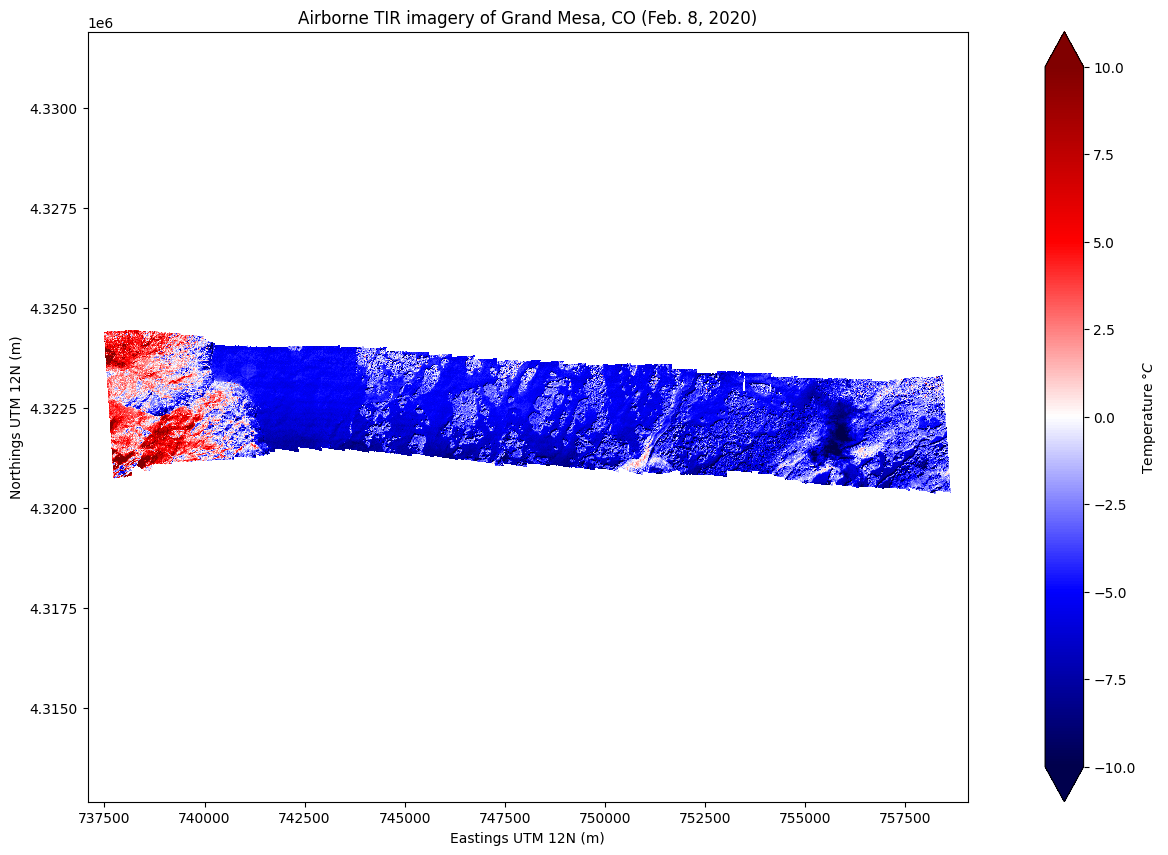

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_aspect("equal")

# plot the airborne infrared image
airborne_ir.plot(
    cmap="seismic",
    vmin=-10,
    vmax=10,
    ax=ax,  # Lab Instructions: You should choose an appropriate color map and range.
    cbar_kwargs={"label": "Temperature $\degree C$"},
)

# set axes labels
ax.set_xlabel("Eastings UTM 12N (m)")
ax.set_ylabel("Northings UTM 12N (m)")

ax.set_title("Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)");

4. To help with our image interpretation, we can load visible imagery taken concurrently from the UW-APL airborne instrument. 

In [7]:
airborne_vis = rioxarray.open_rasterio(
    f"{TUTORIAL_DATA}/SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif"
)
# note that the filename is identical with the same timestamp, but is labeled "EO" (electro-optical) rather than "IR" (infrared)

# Also reproject the airborne visible imagery into EPSG:26912
airborne_vis = airborne_vis.rio.reproject(
    "EPSG:26912"
)  # overwrite itself with new reprojected data array

airborne_vis

<xarray.DataArray (band: 1, y: 3848, x: 4398)> Size: 68MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 3848, 4398), dtype=float32)
Coordinates:
  * x            (x) float64 35kB 7.371e+05 7.371e+05 ... 7.591e+05 7.591e+05
  * y            (y) float64 31kB 4.332e+06 4.332e+06 ... 4.313e+06 4.313e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    description:    visible imagery
    timezone:       time in UTC
    units:          digital numbers
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      SRGB
    _FillValue:     nan

- Plot the visible and infrared images side by side. This time, we will change the x and y axes limits (set_xlim, and set_ylim) to zoom in closer.

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/1364403141.py:9: SyntaxWarning: invalid escape sequence '\d'
  cbar_kwargs={"label": "Temperature $\degree C$"},


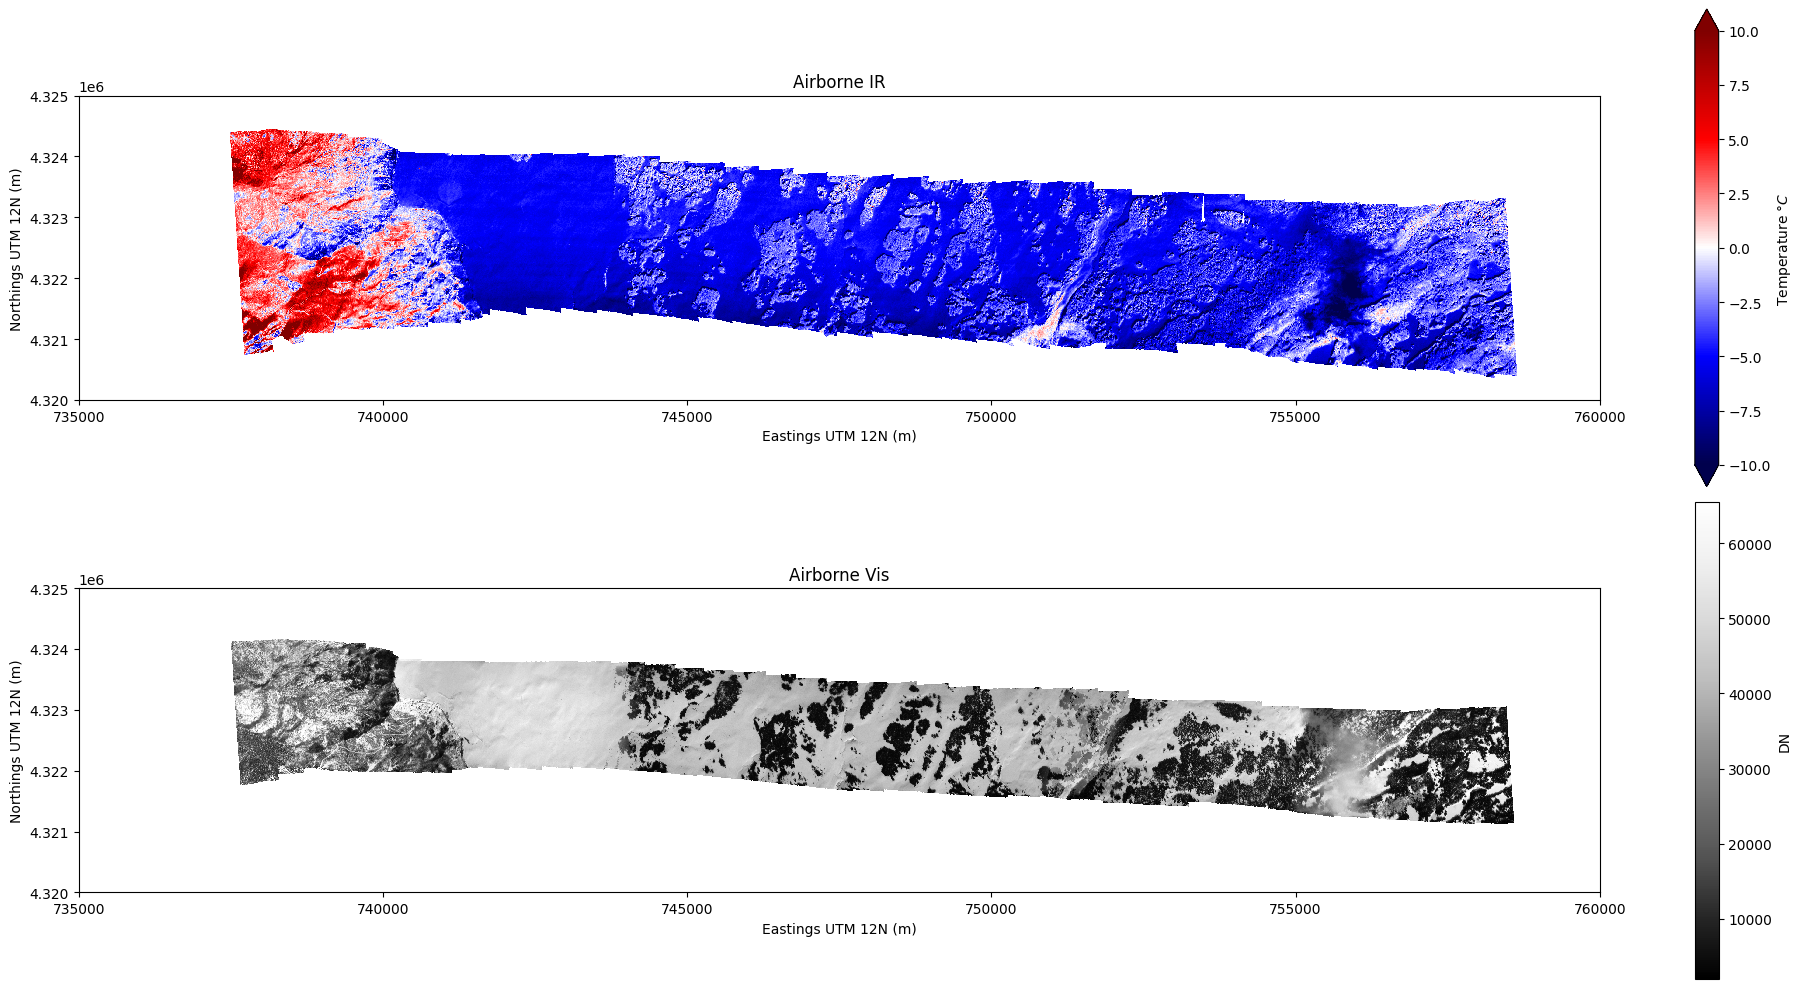

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), tight_layout=True)

# Plot the IR imagery
airborne_ir.plot(
    ax=axs[0],
    cmap="seismic",  # Lab Instructions: You should choose an appropriate color map and range.
    vmin=-10,
    vmax=10,
    cbar_kwargs={"label": "Temperature $\degree C$"},
)
axs[0].set_title("Airborne IR")

# Plot the visible imagery
airborne_vis.plot(ax=axs[1], cmap="Greys_r", cbar_kwargs={"label": "DN"})
axs[1].set_title("Airborne Vis")

# for each subplot, do the following:
for ax in axs:
    ax.set_aspect("equal")  # set the aspect ratio to "equal"

    # give each axis a label
    ax.set_xlabel("Eastings UTM 12N (m)")
    ax.set_ylabel("Northings UTM 12N (m)")

    # set the axes limits, units in meters UTM Zone 12N (I chose these values by just looking at the plot above)
    ax.set_xlim((735000, 760000))  # x axis limits
    ax.set_ylim((4320000, 4325000))  # y axis limits

> **Lab Question (2):** 
> <ol type="a"> 
> <li> Looking at both the visible and IR imageries, what is your interpretations about temperatures here?  </li>
> <li> Can you tell what the cold object on the eastern side of the image is? </li>


------

## Ground-based temperature observations 

To provide a source of “ground truth” for the airborne thermal infrared images during the SnowEx 2020 Grand Mesa campaign, we will use ground-based snow surface temperature measurements. 

On February 5, 2020, the SnowEx team installed a thermal infrared radiometer pointing at the snow surface at snow pit #2S10 (left), and buried temperature sensors beneath the snow surface (right). These logged observations at 5-minute intervals until they are removed a week later on February 12.

<p align = "center"> 
<img src="./images/snowpit_2s10.png" alt="snowpit" width="1000"/> </p>
<em> Fig.2. Snow temperature sensor setup at snow pit 2S10: (left) tripod-mounted thermal ifrared radiometer to measure snow surface, (right) temperature probes to be buried beneath the snow surface.
(Photos by Steven Pestana)</em>

> **Lab Question (3):** 
> <ol type="a"> 
> <li> Before running anything, can you list some of the differences we might expect to see between the ground-based surface temperature data and the thermal IR images? (e.g., emissivity, resolution, accuracy)  </li>


2. Import the snow temperature timeseries dataset

- This data is available through NSIDC, but we have already downloaded a local copy for this tutorial located in the <code>snow-temperature-timeseries</code> subfolder inside <code>thermal-ir</code>. You can read more about this raw data file from the dataset’s README.txt in this subfolder. 

In [9]:
# First, we will create a list of column headers according to the readme file:

column_headers = [
    "table",
    "year",
    "doy",
    "time",  # year, day of year, time of day (local time, UTC-7)
    "rad_avg",
    "rad_max",
    "rad_min",
    "rad_std",  # radiometer surface temperature
    "sb_avg",
    "sb_max",
    "sb_min",
    "sb_std",  # radiometer sensor body temperature (for calibration)
    "temp1_avg",
    "temp1_max",
    "temp1_min",
    "temp1_std",  # temperature at 5 cm below snow surface
    "temp2_avg",
    "temp2_max",
    "temp2_min",
    "temp2_std",  #               10 cm
    "temp3_avg",
    "temp3_max",
    "temp3_min",
    "temp3_std",  #               15 cm
    "temp4_avg",
    "temp4_max",
    "temp4_min",
    "temp4_std",  #               20 cm
    "temp5_avg",
    "temp5_max",
    "temp5_min",
    "temp5_std",  #               30 cm
    "batt_a",
    "batt_b",  # battery voltage data
]

df = pd.read_csv(
    f"{TUTORIAL_DATA}/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat",
    header=None,
    names=column_headers,
)


# Next, we will do database cleanup to make it easier to read:

# create a zero-padded time string (e.g. for 9:30 AM we are changing '930' into '0930')
df["time_str"] = [
    ("0" * (4 - len(str(df.time[i])))) + str(df.time[i]) for i in range(df.shape[0])
]

# locate where rows have time_str == 2400 (midnight), and the whole column 'doy'
# where we are at midnight, we need to shift one day forward
df.loc[df["time_str"] == "2400", "doy"] += 1

# and then change midnight from '2400' to '0000'
df.replace({"time_str": {"2400": "0000"}}, inplace=True)


# create a new column 'datetime' by combining 'year', 'doy', and 'time_str'
def compose_date(
    years,
    months=1,
    days=1,
    weeks=None,
    hours=None,
    minutes=None,
    seconds=None,
    milliseconds=None,
    microseconds=None,
    nanoseconds=None,
):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = (
        "<M8[Y]",
        "<m8[M]",
        "<m8[D]",
        "<m8[W]",
        "<m8[h]",
        "<m8[m]",
        "<m8[s]",
        "<m8[ms]",
        "<m8[us]",
        "<m8[ns]",
    )
    vals = (
        years,
        months,
        days,
        weeks,
        hours,
        minutes,
        seconds,
        milliseconds,
        microseconds,
        nanoseconds,
    )
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals) if v is not None)


# Create a datetime value from the date field and zero-padded time_str field, set this as our dataframe's index
df.index = compose_date(
    df["year"],
    days=df["doy"],
    hours=df["time_str"].str[:2],
    minutes=df["time_str"].str[2:],
)

# Remove entries that are from table "102" (this contains datalogger battery information we're not interested in at the moment)
df = df[df.table != 102]

# drop the columns we no longer need
df.drop(
    columns=["table", "year", "doy", "time", "time_str", "batt_a", "batt_b"],
    inplace=True,
)

# Inspect the ground-based snow temperature database:
df.head()

,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,sb_min,sb_std,temp1_avg,temp1_max,...,temp3_min,temp3_std,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std
2020-01-30 15:37:00,22.963,22.963,22.963,0.000,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:38:00,22.962,22.963,22.961,0.001,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:39:00,25.080,26.810,22.968,1.484,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:40:00,25.320,25.569,25.133,0.184,22.839,22.846,22.832,0.005,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:41:00,24.894,25.069,24.611,0.182,22.860,22.860,22.860,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0


3. Now, we're ready to make plot the ground-based snowpit temperature data. We are interested in the variable rad_avg which is the average temperature measured by the radiometer over each 5 minute period.

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/3626598714.py:33: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("Temperature [$C\degree$]")


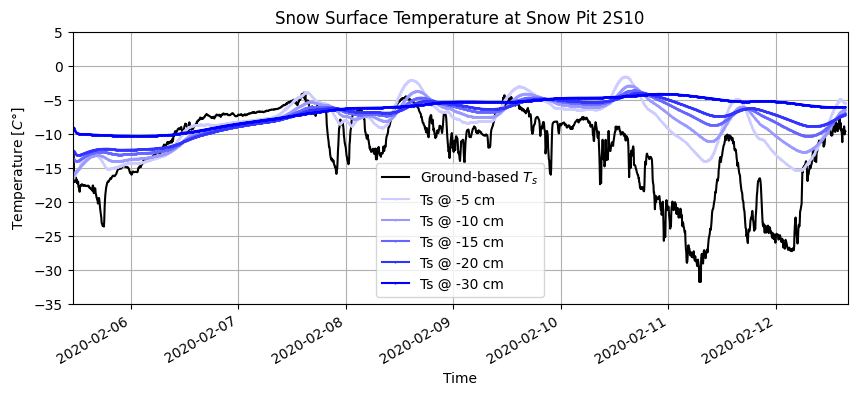

In [10]:
plt.figure(figsize=(10, 4))

# plot radiometer average surface temperature
df.rad_avg.plot(
    linestyle="-", marker="", markersize=1, c="k", label="Ground-based $T_s$"
)

# plot the snow temperature at each depth it was measured
df.temp1_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.8, 0.8, 1], label="Ts @ -5 cm"
)
df.temp2_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.6, 0.6, 1], label="Ts @ -10 cm"
)
df.temp3_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.4, 0.4, 1], label="Ts @ -15 cm"
)
df.temp4_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.2, 0.2, 1], label="Ts @ -20 cm"
)
df.temp5_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0, 0, 1], label="Ts @ -30 cm"
)

# set axes limits
plt.ylim((-35, 5))
plt.xlim((pd.Timestamp(2020, 2, 5, 11, 0), pd.Timestamp(2020, 2, 12, 16, 0)))

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel("Temperature [$C\degree$]")
plt.xlabel("Time")

# add grid lines to the plot
plt.grid("on")

# set the plot title
plt.title("Snow Surface Temperature at Snow Pit 2S10");

- We're mainly interested looking at the ground-based data that were taken at the same time as the airborne IR image. So we can zoom in on Feb 8th by changing our plot’s xlim (using pandas Timestamps for the x axis values).

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/1919758276.py:33: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("Temperature [$C\degree$]")


Text(0.5, 1.0, 'Snow Surface Temperature at Snow Pit 2S10')

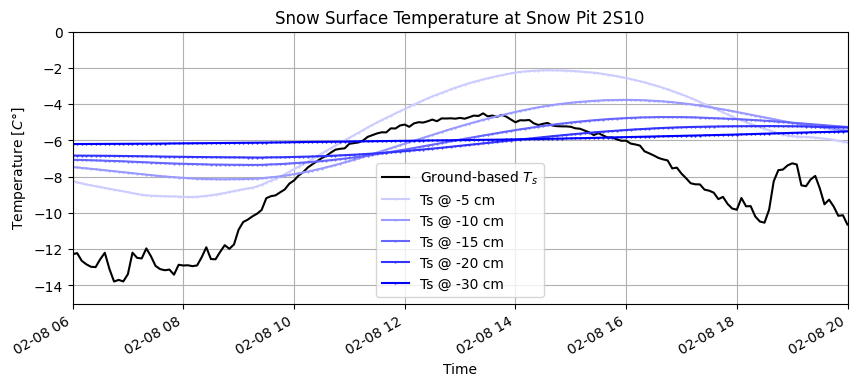

In [11]:
plt.figure(figsize=(10, 4))

# plot radiometer average temperature
df.rad_avg.plot(
    linestyle="-", marker="", markersize=1, c="k", label="Ground-based $T_s$"
)

# plot the snow temperature at each depth it was measured
df.temp1_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.8, 0.8, 1], label="Ts @ -5 cm"
)
df.temp2_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.6, 0.6, 1], label="Ts @ -10 cm"
)
df.temp3_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.4, 0.4, 1], label="Ts @ -15 cm"
)
df.temp4_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.2, 0.2, 1], label="Ts @ -20 cm"
)
df.temp5_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0, 0, 1], label="Ts @ -30 cm"
)

# set axes limits
plt.ylim((-15, 0))  # set some temperature y-axis limits for our plot
plt.xlim((pd.Timestamp(2020, 2, 8, 6, 0), pd.Timestamp(2020, 2, 8, 20, 0)))

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel("Temperature [$C\degree$]")
plt.xlabel("Time")

# add grid lines to the plot
plt.grid("on")

# set the plot title
plt.title("Snow Surface Temperature at Snow Pit 2S10")

> **Lab Question (4):** 
> <ol type="a"> 
> <li> From the zoom-in plot above, describe how the snow surface temperature (black line) varies on Feb 8. </li>
> <li> How does the temperature varies with depth (blue lines)? What processes could be controling this depth-variation in temperature? </li>


-----------

<>:58: SyntaxWarning: invalid escape sequence '\d'
<>:58: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/3731672429.py:58: SyntaxWarning: invalid escape sequence '\d'
  cbar_kwargs={'label': 'Temperature $\degree C$'})


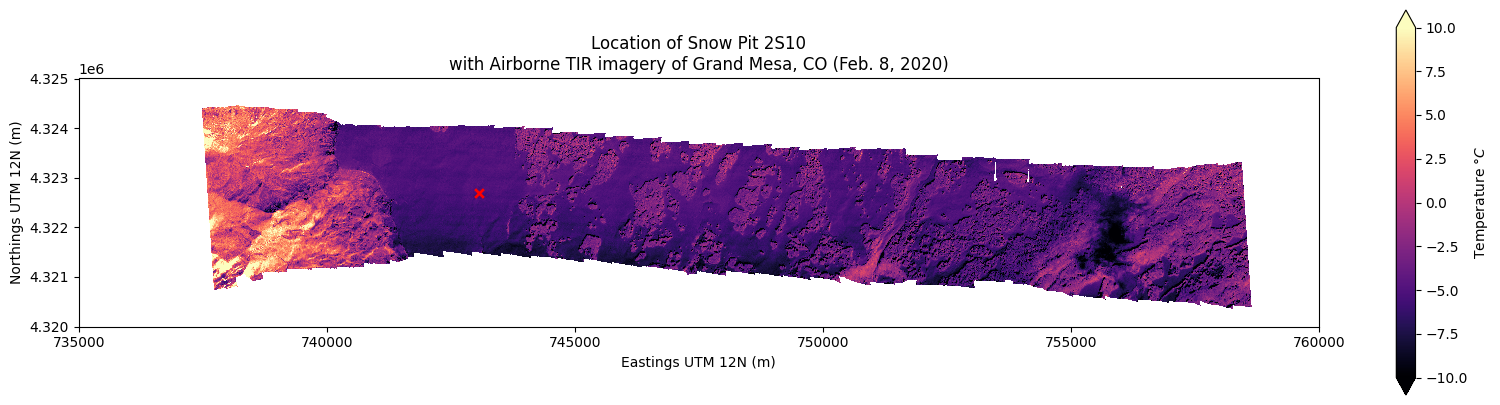

In [ ]:
from snowexsql.db import get_db
from snowexsql.data import ImageData, SiteData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape
import geopandas as gpd
from snowexsql.conversions import raster_to_rasterio
from snowexsql.conversions import points_to_geopandas, query_to_geopandas
import matplotlib.pyplot as plt
import numpy as np

site_id = "2S10"
buffer_dist = 400
db_name = "snow:hackweek@db.snowexdata.org/snowex"
engine, session = get_db(db_name)

datasets = []

# Grab our sites details by site id
q = session.query(SiteData).filter(SiteData.site_id == site_id)
siteData_df = query_to_geopandas(q, engine)
sites = q.all()

# Grab the pit location from a single layer
p = sites[0].geom

# Convert the point to a pyshapely
pit = to_shape(p)

# Convert it to a geopandas dataframe for easy plotting
df_pit = gpd.GeoSeries(pit)

# Create a polygon buffered by our distance centered on the pit
q = session.query(gfunc.ST_Buffer(p, buffer_dist))
buffered_pit = q.all()[0][0]

# Convert to a shapely shapefile object
circle = to_shape(buffered_pit)

# Convert to a geopandas dataframe
df_circle = gpd.GeoSeries(circle)

# Form a query for retrieving the sites that are within the circle
q = session.query(SiteData.geom).filter(gfunc.ST_Within(SiteData.geom, buffered_pit))

# Create a geopandas dataframe of SiteData geometry in the circle
nearby_pits = query_to_geopandas(q, engine)

# Print Data:
siteData_df
siteData_df.crs
siteData_df.geometry
fig, ax = plt.subplots(
    figsize=(20, 5)
)  # create a new matplotlib figure, set the figure size
ax.set_aspect("equal")  # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(
    cmap="magma",
    vmin=-10,
    vmax=10,
    ax=ax,
    cbar_kwargs={"label": "Temperature $\degree C$"},
)

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color="r", marker="x")

# set axes labels
ax.set_xlabel("Eastings UTM 12N (m)")
ax.set_ylabel("Northings UTM 12N (m)")

# set the axes limits, units in meters UTM Zone 12N (I chose these values by just looking at the plot above)
ax.set_xlim((735000, 760000))  # x axis limits
ax.set_ylim((4320000, 4325000))  # y axis limits

# set plot title
ax.set_title(
    "Location of Snow Pit 2S10\nwith Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)"
);

# Compare Airborne IR against the “ground truth” snow surface temperature

In [35]:
# clip using our point's geometry
airborne_ir_point_temperature = airborne_ir.rio.clip(siteData_df.geometry)

# preview the result
airborne_ir_point_temperature

<xarray.DataArray (band: 1, y: 1, x: 1)> Size: 4B
array([[[-5.038153]]], dtype=float32)
Coordinates:
  * x            (x) float64 8B 7.431e+05
  * y            (y) float64 8B 4.323e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    description:    Airborne thermal infrared imagery from University of Wash...
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      STCtemp
    _FillValue:     nan

In [ ]:
r = 100  # radius of the buffer in meters (this is in meters because we are working in a UTM coordinate reference system)

# create the buffered geometry
siteData_df_buffer = siteData_df.buffer(r)

# preview the resulting geometry, we should see this is a POLYGON now
siteData_df_buffer

0    POLYGON ((743176 4322689, 743175.518 4322679.1...
1    POLYGON ((743176 4322689, 743175.518 4322679.1...
2    POLYGON ((743176 4322689, 743175.518 4322679.1...
3    POLYGON ((743176 4322689, 743175.518 4322679.1...
4    POLYGON ((743176 4322689, 743175.518 4322679.1...
dtype: geometry

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/1836911766.py:6: SyntaxWarning: invalid escape sequence '\d'
  cbar_kwargs={'label': 'Temperature $\degree C$'})


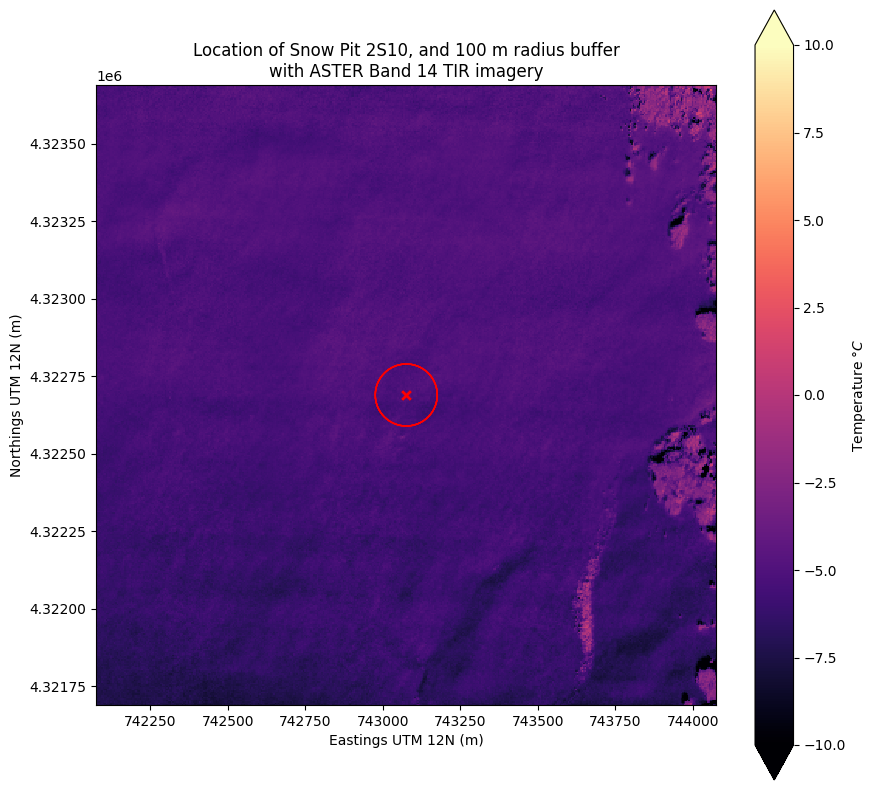

In [ ]:
fig, ax = plt.subplots(
    figsize=(10, 10)
)  # create a new matplotlib figure, set the figure size
ax.set_aspect("equal")  # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(
    cmap="magma",
    vmin=-10,
    vmax=10,
    ax=ax,
    cbar_kwargs={"label": "Temperature $\degree C$"},
)

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color="r", marker="x")

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax, edgecolor="r", facecolor="none")

xmin, ymin, xmax, ymax = siteData_df.geometry.total_bounds
ax.set_xlim(
    (xmin - 1000, xmax + 1000)
)  # x axis limits to +/- 1 km from our point's "total bounds"
ax.set_ylim(
    (ymin - 1000, ymax + 1000)
)  # y axis limits to +/- 1 km from our point's "total bounds"

# set axes labels
ax.set_xlabel("Eastings UTM 12N (m)")
ax.set_ylabel("Northings UTM 12N (m)")

# set plot title
ax.set_title(
    "Location of Snow Pit 2S10, and 100 m radius buffer\nwith ASTER Band 14 TIR imagery"
);

In [40]:
# clip using our new geometry
airborne_ir_area_temperature = airborne_ir.rio.clip(siteData_df_buffer.geometry)

# preview the result
airborne_ir_area_temperature

<xarray.DataArray (band: 1, y: 40, x: 40)> Size: 6kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 40, 40), dtype=float32)
Coordinates:
  * x            (x) float64 320B 7.43e+05 7.43e+05 ... 7.432e+05 7.432e+05
  * y            (y) float64 320B 4.323e+06 4.323e+06 ... 4.323e+06 4.323e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    description:    Airborne thermal infrared imagery from University of Wash...
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      STCtemp
    _FillValue:     nan

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/849800024.py:5: SyntaxWarning: invalid escape sequence '\d'
  cbar_kwargs={'label': 'Temperature $\degree C$'})


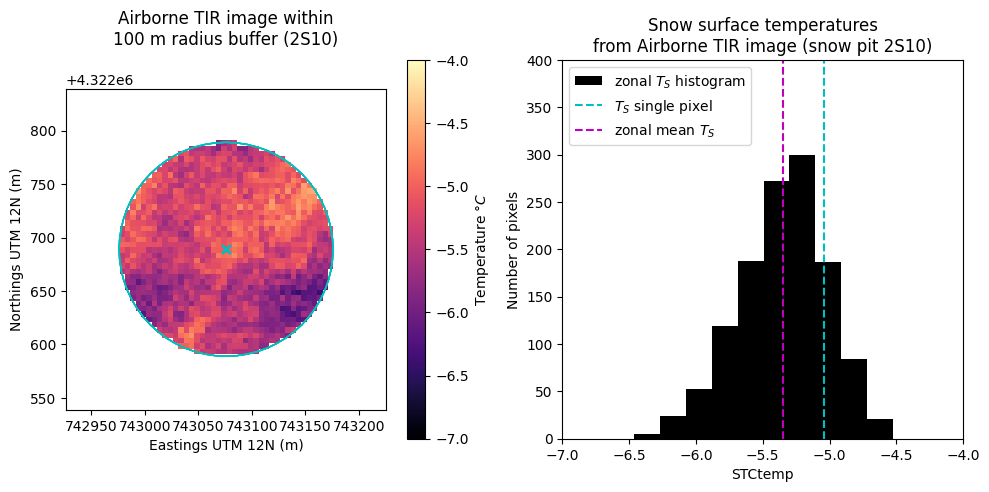

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)

# plot the portion of the airborne TIR image we selected within the buffer area geometry
airborne_ir_area_temperature.plot(
    cmap="magma",
    vmin=-7,
    vmax=-4,
    ax=ax[0],
    cbar_kwargs={"label": "Temperature $\degree C$"},
)
ax[0].set_title("Airborne TIR image within\n100 m radius buffer (2S10)\n")
ax[0].set_aspect("equal")
ax[0].set_xlabel("Eastings UTM 12N (m)")
ax[0].set_ylabel("Northings UTM 12N (m)")
ax[0].set_xlim(
    (xmin - 150, xmax + 150)
)  # x axis limits to +/- 150 m from our point's "total bounds"
ax[0].set_ylim(
    (ymin - 150, ymax + 150)
)  # y axis limits to +/- 150 m from our point's "total bounds"

# plot the location of the snow pit of interest to the plot
siteData_df.plot(ax=ax[0], color="c", marker="x")

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax[0], edgecolor="c", facecolor="none")

# plot a histogram of image temperature data within the buffer area geometry
airborne_ir_area_temperature.plot.hist(
    ax=ax[1],
    color="k",
    zorder=1,  # use zorder to make sure this plots below the point
    label="zonal $T_S$ histogram",
)

# plot a vertical line for the single-pixel temperature we think is right at the snow pit
ax[1].axvline(
    airborne_ir_point_temperature,
    color="c",
    linestyle="--",  # set color and style
    zorder=2,  # use zorder to make sure this plots on top of the histogram
    label="$T_S$ single pixel",
)

# plot a vertical line for the mean temperature within the buffer area geometry
ax[1].axvline(
    airborne_ir_area_temperature.mean(),
    color="m",
    linestyle="--",  # set color and style
    zorder=2,  # use zorder to make sure this plots on top of the histogram
    label="zonal mean $T_S$",
)

ax[1].legend(loc="upper left")  # add a legend
ax[1].set_xlim((-7, -4))  # set xlim to same values as colorbar in image plot
ax[1].set_ylim((0, 400))  # set ylim
ax[1].set_title("Snow surface temperatures\nfrom Airborne TIR image (snow pit 2S10)")
ax[1].set_ylabel("Number of pixels");

<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/2932538288.py:27: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('Temperature [$C\degree$]')
/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_36969/2932538288.py:7: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),


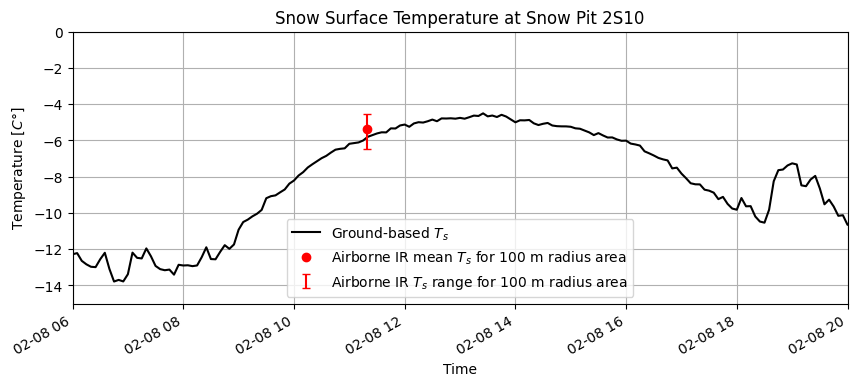

In [ ]:
plt.figure(figsize=(10, 4))

# plot radiometer average temperature
df.rad_avg.plot(
    linestyle="-", marker="", markersize=1, c="k", label="Ground-based $T_s$"
)

# plot the mean airborne IR temperature from the area around the snow pit:
plt.plot(
    airborne_ir_timestamp,
    airborne_ir_area_temperature.mean(),
    marker="o",
    c="r",
    linestyle="none",
    label="Airborne IR mean $T_s$ for 100 m radius area",
)

# plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
plt.errorbar(
    airborne_ir_timestamp,
    airborne_ir_area_temperature.mean(),
    yerr=[
        [airborne_ir_area_temperature.mean() - airborne_ir_area_temperature.min()],
        [airborne_ir_area_temperature.max() - airborne_ir_area_temperature.mean()],
    ],
    capsize=3,
    fmt="none",
    ecolor="r",
    label="Airborne IR $T_s$ range for 100 m radius area",
)


# set axes limits
plt.ylim((-15, 0))
plt.xlim(
    (pd.Timestamp(2020, 2, 8, 6, 0), pd.Timestamp(2020, 2, 8, 20, 0))
)  # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel("Temperature [$C\degree$]")
plt.xlabel("Time")

# add grid lines to the plot
plt.grid("on")

# set the plot title
plt.title("Snow Surface Temperature at Snow Pit 2S10");